## <span style='color:orange'>Desarrollo del modelo de clasificación supervisada.</span>


**Este cuaderno presenta la última etapa del flujo de trabajo para la clasificación de cerámicas arqueológicas**

Contiene:


* Preprocesamiento y re muestreo
* Experimentación y comparación de algoritmos
* Optimización
* Validación final
 



#### **Nuestra función de clasificación; X = (578 x 18), y = 4 clases ("Tipos")**


In [1]:
#Para reproducir en Colab descomenta las líneas siguientes antes de ejecutar el cuaderno
#!pip install pycaret
#from pycaret.utils import enable_colab
#enable_colab()
import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report
from ipywidgets import widgets # Interactive functions
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('./intermediate_data/datos_supervisado.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Unnamed: 0       578 non-null    int64
 1   Coccion          578 non-null    int64
 2   T_desgrasante    578 non-null    int64
 3   Composicion      578 non-null    int64
 4   Densidad         578 non-null    int64
 5   Textura          578 non-null    int64
 6   Grosor₍mm)       578 non-null    int64
 7   Tamaño(cm)       578 non-null    int64
 8   Acabado_Interno  578 non-null    int64
 9   Acabado_Externo  578 non-null    int64
 10  Dureza           578 non-null    int64
 11  Ahumado          578 non-null    int64
 12  Tecnica          578 non-null    int64
 13  Elemento₁        578 non-null    int64
 14  Localizacion     578 non-null    int64
 15  Baño             578 non-null    int64
 16  Engobe           578 non-null    int64
 17  cluster          578 non-null    int64
dtypes: int64(1

In [4]:
df= df.drop(['Unnamed: 0'], axis=1)
df.isnull().any().any()

False

In [9]:
target = df['cluster'].value_counts()
target

2    467
1     90
4     11
3     10
Name: cluster, dtype: int64

#### Creando el set de validación final VS1 (10% de los datos)

Reservamos estos datos para que no esten expuestos al proceso de entrenamiento del modelo y puedan ser usados como datos no-vistos por el modelo

In [10]:
# Validation set 1 (VS1)
data = df.sample(frac=0.90, random_state=786)
vs1 = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
vs1.reset_index(inplace=True, drop=True)
print('Data for further procedures: ' + str(data.shape))
print('Data for final validation: ' + str(vs1.shape))
#vs1.to_csv('./TABLES/validation_set1.csv')

Data for further procedures: (520, 17)
Data for final validation: (58, 17)


#### Creando nuestra función de clasificación:

In [11]:
X = df.drop(['cluster'], axis=1)
y = df['cluster']

####  Remuestreo de las clases minoritarias (SMOTE)
Construimos datos sintéticos de las clases menores para balancear el dataset

1    467
2    467
4    467
3    467
Name: cluster, dtype: int64

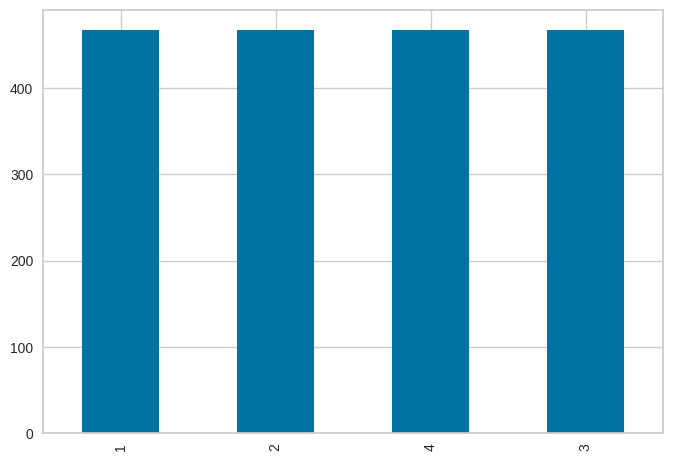

In [12]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

In [13]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['target'] = y_smote

### Hemos creado un conjunto de datos equilibrado con datos sintéticos en las clases menores

In [14]:
# Final dataset shape after resampling
smote_data.shape
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Coccion          1868 non-null   int64
 1   T_desgrasante    1868 non-null   int64
 2   Composicion      1868 non-null   int64
 3   Densidad         1868 non-null   int64
 4   Textura          1868 non-null   int64
 5   Grosor₍mm)       1868 non-null   int64
 6   Tamaño(cm)       1868 non-null   int64
 7   Acabado_Interno  1868 non-null   int64
 8   Acabado_Externo  1868 non-null   int64
 9   Dureza           1868 non-null   int64
 10  Ahumado          1868 non-null   int64
 11  Tecnica          1868 non-null   int64
 12  Elemento₁        1868 non-null   int64
 13  Localizacion     1868 non-null   int64
 14  Baño             1868 non-null   int64
 15  Engobe           1868 non-null   int64
 16  target           1868 non-null   int64
dtypes: int64(17)
memory usage: 248.2 KB


### Desarrollo del modelo:

Una vez el pre-preocesamiento está finalizado, podemos entrenar y evaluar diferentes modelos supervisados.
Para la evaluación y comparación de diferentes algortimos hemos utilizado la técnica de validaicón cruzada estratificada, usando el 80% de los datos para el entrenamiento. Todo el proceso de desarrollo del modelo lo hemos realizado usando la libreria Pycaret, una herramienta open-source de bajo codigo para machine-learning sobre los algoritmos de scikit-learn


**El parametro session_id parameter genera una semilla que asegura la reproducibilidad de los experimentos**

In [15]:
experiment = setup(data=data, target= 'cluster',train_size=0.8, session_id=123)


,Description,Value
0,Session id,123
1,Target,cluster
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3"
4,Original data shape,"(520, 17)"
5,Transformed data shape,"(520, 17)"
6,Transformed train set shape,"(416, 17)"
7,Transformed test set shape,"(104, 17)"
8,Numeric features,16
9,Preprocess,True


In [ ]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [16]:
training_data = get_config(variable="X_train")

###  Experimentación de algoritmos

Esta función entrena y evalua el desempeño de diferentes clasificadores disponibles en la libreria.
 El resultado es una tabla de resultados con los puntajes promediados por medio de validación cruzada con k= 10 iteraciones.


In [18]:
# Algorithm Experimentation
compare_models(exclude = ['dummy', 'gbc', 'catboost'])

,Model,Accuracy,Recall,Prec.,F1,TT (Sec)
et,Extra Trees Classifier,0.9855,0.9855,0.9725,0.9787,0.1200
rf,Random Forest Classifier,0.9760,0.9760,0.9543,0.9646,0.0830
xgboost,Extreme Gradient Boosting,0.9736,0.9736,0.9659,0.9686,0.0590
lr,Logistic Regression,0.9712,0.9712,0.9524,0.9611,0.4550
dt,Decision Tree Classifier,0.9688,0.9688,0.9592,0.9621,0.0460
ada,Ada Boost Classifier,0.9617,0.9617,0.9378,0.9489,0.1460
svm,SVM - Linear Kernel,0.9593,0.9593,0.9447,0.9511,0.0470
ridge,Ridge Classifier,0.9592,0.9592,0.9477,0.9526,0.0320
lightgbm,Light Gradient Boosting Machine,0.9449,0.9449,0.9358,0.9378,0.2040
nb,Naive Bayes,0.9304,0.9304,0.9428,0.9342,0.0430


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)

In [20]:
results = pull()
#results.to_csv('/home/dsg/Escritorio/CCA2024/TABLES/model_benchmarking.csv')
models = results.Model.tolist()


#### Creando el modelo. 
En esta sección podemos escoger que modelo queremos crear. 
Por motivos de explicabilidad hemos seleccionado el Random Forest, ya que permite una exploraicón transparente del proceso clasificatorio, además nos permite calcular la importancia de las variables mediante el computo de la entropía, lo que podriamos utilizar como criterio para encontrar las variables diagnosticas del modelo

In [21]:
# Selecting a model
method = widgets.Dropdown(options=models,description='Method')
display(method)

Dropdown(description='Method', options=('Extra Trees Classifier', 'Random Forest Classifier', 'Extreme Gradien…

In [22]:
#creating the model selected
model_mappings = {
    
    'Light Gradient Boosting Machine': ('lightgbm', {'class_weight': 'balanced'}),
    'Extreme Gradient Boosting': ('xgboost', {}),
    'Extra Trees Classifier': ('et', {}),
    'Random Forest Classifier': ('rf', {}),
    'Decision Tree Classifier': ('dt', {}),
    'K Neighbors Classifier': ('knn', {}),
    'Naive Bayes': ('nb', {}),
    'Linear Discriminant Analysis': ('lda', {}),
    'Ridge Classifier': ('ridge', {}),
    'SVM - Linear Kernel': ('svm', {}),
    'Quadratic Discriminant Analysis': ('qda', {}),
    'Ada Boost Classifier': ('ada', {}),
    'Logistic Regression': ('lr', {}),
}

model_name, model_args = model_mappings.get(method.value, (None, None))

if model_name is not None:
    model = create_model(model_name, **model_args)
else:
    print("Method not found or not yet implemented.")


,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9762,0.9762,0.9558,0.9652
1,0.9524,0.9524,0.9088,0.9297
2,1.0000,1.0000,1.0000,1.0000
3,0.9524,0.9524,0.9088,0.9297
4,0.9762,0.9762,0.9531,0.9645
5,0.9762,0.9762,0.9558,0.9652
6,0.9756,0.9756,0.9543,0.9642
7,0.9756,0.9756,0.9543,0.9642
8,0.9756,0.9756,0.9519,0.9636


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
# Model parameters
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

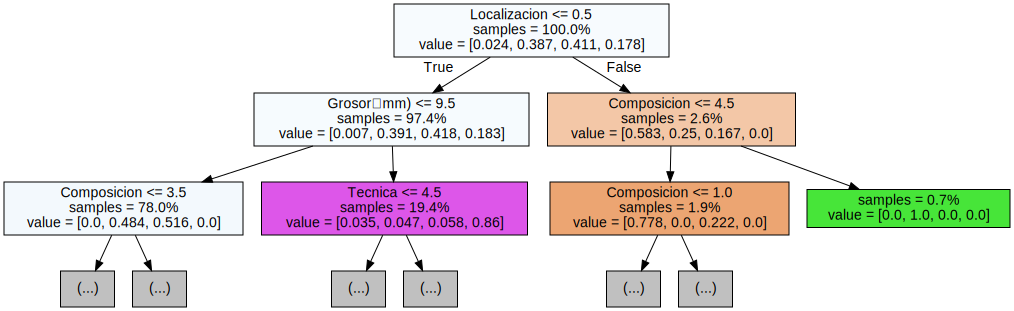

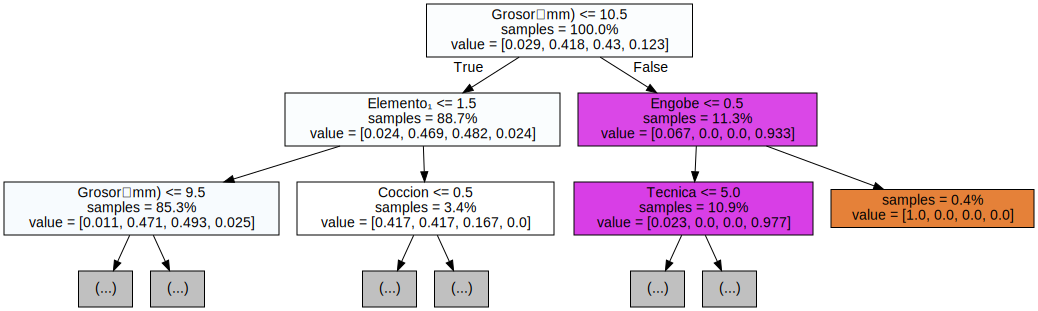

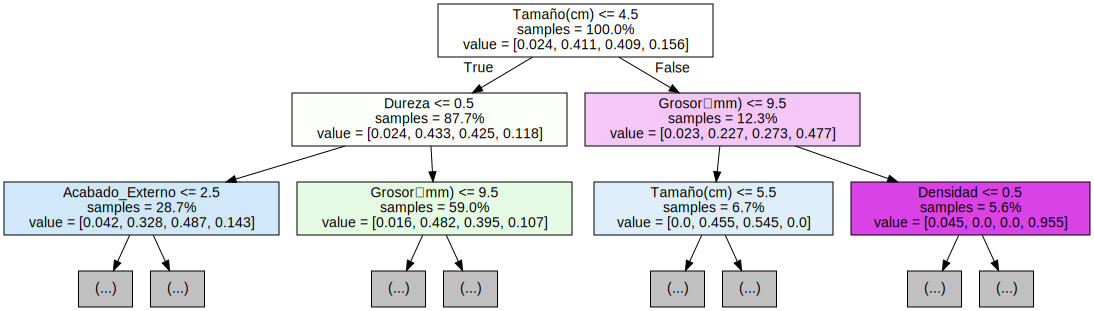

'temp_file.png'

In [24]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
training_data = get_config(variable="X_train")
for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=training_data.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)
    
fie_ext = 'png'
temp_img = 'temp_file'
graph.render(temp_img,format=fie_ext, view=False)


In [ ]:
model_score_grid = pull()
model_score_grid.to_csv('./intermediate_data/modelrf_score_before_tuning.csv')

### Optimización del modelo 

Esta función optimiza los hiperparametros del modelo creado. El resultado es una tabla de puntajes para una validación cruzada de k=10 iteraciones del modelo con la mejor combinación de parametros de acuerdo al método seleccionado.

Por defecto, la función prioriza el Accuracy como metrica para decidir entre los mejores candidatos.

Esta función usa el algoritmo ```RandomizedSearchCV()``` de scikit-learn por defecto.

```n_iter``` parameter defines the number of iterations in the search space.

```Warning: this process could be computationally intensive dependending of your resources.``` 

See [Workflow.ipynb](./Workflow.ipynb) for resources used 


In [23]:
tuned_model = tune_model(model, n_iter=10, tuner_verbose=False)#,return_tuner=True)

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9286,0.9286,0.9476,0.9372
1,0.9762,0.9762,0.9558,0.9652
2,0.9762,0.9762,0.9558,0.9652
3,0.9524,0.9524,0.9088,0.9297
4,0.9524,0.9524,0.9088,0.9297
5,0.9762,0.9762,0.9881,0.9791
6,0.9756,0.9756,0.9543,0.9642
7,0.9756,0.9756,0.9878,0.9787
8,0.9756,0.9756,0.9519,0.9636


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
tuned_model_score_grid = pull()
tuned_model_score_grid.to_csv('./intermediate_data/tuned_classifier_score.csv')

### Validación
#### En este paso, el modelo es evlauado con los datos de test (20%): 


In [24]:
predictions = predict_model(tuned_model);
predictions.head()

,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9904,0.9904,0.9910,0.9889


,Coccion,T_desgrasante,Composicion,Densidad,Textura,Grosor₍mm),Tamaño(cm),Acabado_Interno,Acabado_Externo,Dureza,Ahumado,Tecnica,Elemento₁,Localizacion,Baño,Engobe,cluster,prediction_label,prediction_score
331,0,2,0,0,0,8,3,1,1,0,0,0,0,0,0,0,1,2,0.98
297,0,1,6,0,0,8,2,2,2,1,0,0,0,0,0,0,1,2,1.00
149,0,2,6,0,0,8,3,2,2,1,0,0,0,0,0,0,1,2,1.00
240,1,0,0,0,0,10,4,3,3,0,0,0,0,0,0,0,1,2,1.00
117,1,0,5,0,0,7,3,3,3,1,0,0,0,0,0,0,1,2,1.00


#### Iteración final de entrenamiento con todos los datos (80% training + 20% testing)



In [25]:
final_model = finalize_model(tuned_model)# Final training iteration with all available data

In [27]:
vs1.cluster.value_counts()

2    47
1    10
4     1
Name: cluster, dtype: int64

#### Evaluación del modelo con los datos reservados de validación final VS1

In [29]:
vs1_predictions = predict_model(final_model, data=vs1)

vs1_for_pred = vs1.drop(['cluster'], axis=1)

vs1_predictions = predict_model(final_model, vs1_for_pred)
vs1_predictions['cluster'] = vs1['cluster']
#metrics for vs1
y_true_vs1 = vs1_predictions['cluster']
y_pred_vs1 = vs1_predictions['prediction_label']
class_rep_vs1 = pd.DataFrame(classification_report(y_true_vs1, y_pred_vs1, output_dict=True)).T

vs1_predictions.to_csv('./intermediate_data/predictions_vs1.csv')
class_rep_vs1.to_csv('./intermediate_data/classification_report_vs1.csv')
class_rep_vs1


,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000


,precision,recall,f1-score,support
1,1.0,1.0,1.0,10.0
2,1.0,1.0,1.0,47.0
4,1.0,1.0,1.0,1.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,58.0
weighted avg,1.0,1.0,1.0,58.0


In [31]:
plot = evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

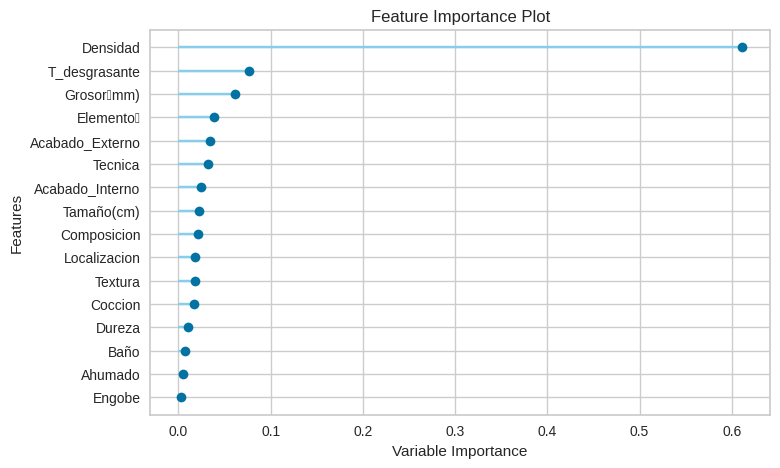

In [30]:
# Visualización de la importancia de las variables
plot_model(final_model, plot = 'feature_all')

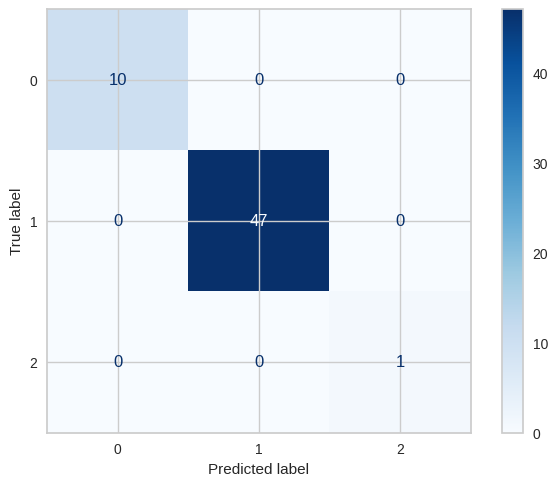

In [32]:
#Visualización de la matriz de confusión

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_vs1,y_pred_vs1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#display_labels=final_model.classes_
disp.plot(cmap='Blues')
#plt.savefig("./intermediate-data/matrix.png",bbox_inches='tight')


### Guardando el modelo entrenado
En esta última etapa podemos guardar el modelo entrenado para usarlo en nuevos casos.


In [33]:
save_model(final_model, model_name = './intermediate_data/classifier',verbose=True)


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Coccion', 'T_desgrasante',
                                              'Composicion', 'Densidad',
                                              'Textura', 'Grosor₍mm)',
                                              'Tamaño(cm)', 'Acabado_Interno',
                                              'Acabado_Externo', 'Durez...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_sam

### Conclusión:

Hemos desarrollado un flujo de trabaj para clasificar cerámica arqueológica usando herramientas de Machine Learning.
Como resultado tenemos un modelo pre-entrenado listo para usar en nuevos casos


* Ve a [caso de uso](Proof-of-concept.ipynb) para ver la utilización del modelo pre-entrenado.
